In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.utils import resample

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
from aif360.algorithms.preprocessing.reweighing import Reweighing

import json

from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


<a id='main'></a>

### Steps in the Data Science Pipeline

1. [Data Preparation](#data_prep)  
2. Bias Detection and Mitigation  
    a. [Bias Detection](#find_bias)  
    b. [Bias Mitigation](#fix_bias)  
3. [Modelling](#data_model)  
    a. [Optimize features](#optimize_features)
4. [Tradeoffs](#tradeoffs)

<a id='data_prep'></a>

### 1. Data Preparation

In [2]:
orig_dataset = GermanDataset(protected_attribute_names=['sex', 'age'])

In [3]:
# fix labels to be 0s and 1s
# originally, 2 = bad credit, 1 = good credit
orig_dataset.labels = np.where(orig_dataset.labels == 2, 0, 1)

In [4]:
orig_dataset.unfavorable_label = 0.0

In [5]:
orig_dataset.metadata['protected_attribute_maps']

[{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]

In [6]:
# check distribution of classes
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['credit'].value_counts()

1.0    700
0.0    300
Name: credit, dtype: int64

<a id='find_bias'></a>

#### Drop redundant variables

In [7]:
df_og = df_og[['credit', 'month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age',
               'number_of_credits', 'people_liable_for', 'sex',
               # dropped status=A14
               'status=A11', 'status=A12', 'status=A13',
               # dropped credit_history=A30
               'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34',
               # dropped purpose=A410
               'purpose=A40', 'purpose=A41', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 
               # dropped savings=A65
               'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 
               # dropped employment=A71
               'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75',
               # dropped other_debtors=A101
               'other_debtors=A102', 'other_debtors=A103',
               # dropped property=A124
               'property=A121', 'property=A122', 'property=A123',
               # dropped installment_pans=A143
               'installment_plans=A141', 'installment_plans=A142',
               # dropped housing=A152
               'housing=A151', 'housing=A153',
               # dropped skill_level=A174
               'skill_level=A171', 'skill_level=A172', 'skill_level=A173',
               # dropped telephone=A191
               'telephone=A192',
               # dropped foreign_workers=A202
               'foreign_worker=A201'
            ]].copy()

In [8]:
orig_dataset = BinaryLabelDataset(df=df_og, label_names=['credit'], protected_attribute_names=['sex', 'age'],
                                  favorable_label=1.0, unfavorable_label=0.0)

In [9]:
display(Markdown("#### Original Dataset shape"))
print(orig_dataset.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(orig_dataset.favorable_label, orig_dataset.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(orig_dataset.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(orig_dataset.privileged_protected_attributes, 
      orig_dataset.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(orig_dataset.feature_names)

#### Original Dataset shape

(1000, 46)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'installment_plans=A141', 'installment_plans=A142', 'housing=A151', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'telephone=A192', 'foreign_worker=A201']


[Go to top](#main)

### 2. Bias Detection and Mitigation

### 2a. Bias Detection

In [10]:
def make_results_table(results, list_of_vars):

    def expand_metric(df, metric, list_of_vars):
        # expand dictionary column into dataframe
        df = df[metric].apply(pd.Series)
        df['name'] = list_of_vars
        # get metric value
        df['message'] = df['message'].astype(str)
        df[metric] = df['message'].apply(lambda x: x.split(':')[1])
        # keep relevant columns
        df = df[['name', metric]].copy()
        df[metric] = df[metric].astype(float).round(2)
        return df
    
    # convert json into dataframe
    df_results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index':'Feature', 
                                                                                               0:'Mean Difference',
                                                                                               1: 'Disparate Impact',
                                                                                               2: 'Consistency'})
    # get column names
    list_of_metrics = df_results.columns[1:].tolist()
    df0 = pd.DataFrame(np.zeros((len(list_of_vars), 1)))
    
    for metric in list_of_metrics:
        df = expand_metric(df_results, metric, list_of_vars)
        df0 = pd.concat([df0,df], axis=1)
    
    # get variable names
    vars_col = df0['name'].iloc[:,0]
    df0.drop(columns=['name', 0], inplace=True)
    df0['Name'] = vars_col
    df0 = df0[['Name', 'Mean Difference', 'Disparate Impact', 'Consistency']].copy()
    return df0


def get_fairness_metrics(dataset):
    # NOTE: dataset expected to a BinaryLabelDataset
    results = {}
    list_of_vars = []
    
    for var in dataset.protected_attribute_names:
        privileged_groups = []
        unprivileged_groups = []

        privileged_groups.append({var: 0})
        unprivileged_groups.append({var: 1})

        metrics = BinaryLabelDatasetMetric(dataset,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)


        json_explainer = MetricJSONExplainer(metrics)
        
        mean_diff = json.loads(json_explainer.mean_difference())
        di = json.loads(json_explainer.disparate_impact())
        # NOTE: json_explainer.consistency() has a bug (https://github.com/Trusted-AI/AIF360/issues/227)
        consist = metrics.consistency(n_neighbors=5)[0]
        # create array to manage around bug in source code
        consist_d = {'metric': 'Consistency',
                     'message': 'Consistency (measures how similar labels are for similar instances): '+str(consist)}

        results[var] = [mean_diff, di, consist_d]
        list_of_vars.append(var)
        
    df = make_results_table(results, list_of_vars)
    return df

#### Get baseline for each protected attribute

In [11]:
get_fairness_metrics(orig_dataset)

,Name,Mean Difference,Disparate Impact,Consistency
0,sex,0.07,1.12,0.68
1,age,0.15,1.26,0.68


<a id='fix_bias'></a>

[Go to top](#main)

### 2b. Bias Mitigation

In [12]:
def reweigh_dataset(privileged_groups, unprivileged_groups, dataset):
    # NOTE: dataset expected to be a BinaryLabelDataset
    privileged_groups = privileged_groups
    unprivileged_groups = unprivileged_groups

    # reweigh training dataset
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)

    RW.fit(dataset)
    dataset_transformed = RW.transform(dataset)
    
    diff = dataset_transformed.instance_weights.sum() - dataset.instance_weights.sum()
    print("The difference in weights between original and transformed dataset is %s" % diff)
    
    return dataset_transformed

In [13]:
# old is privileged, young is unprivileged
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [14]:
dataset_og_rw1 = reweigh_dataset(privileged_groups, unprivileged_groups, orig_dataset)

The difference in weights between original and transformed dataset is 0.0


In [15]:
get_fairness_metrics(dataset_og_rw1)

,Name,Mean Difference,Disparate Impact,Consistency
0,sex,0.04,1.06,0.68
1,age,-0.00,1.00,0.68


In [16]:
# male is privileged, female is unprivileged
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [17]:
dataset_og_rw2 = reweigh_dataset(privileged_groups, unprivileged_groups, dataset_og_rw1)

The difference in weights between original and transformed dataset is -2.2737367544323206e-13


In [18]:
get_fairness_metrics(dataset_og_rw2)

,Name,Mean Difference,Disparate Impact,Consistency
0,sex,-0.00,1.00,0.68
1,age,-0.01,0.98,0.68


<a id='data_model'></a>

In [19]:
dataset_transf = dataset_og_rw2.copy()

[Go to top](#main)

### 3. Modelling

In [20]:
# 70:30 split into train, vt
# 50:50 split into valid, test
dataset_train, dataset_vt = orig_dataset.split([0.7], shuffle=True)
dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

In [21]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_train.favorable_label, dataset_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_train.privileged_protected_attributes, 
      dataset_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_train.feature_names)

#### Training Dataset shape

(700, 46)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'installment_plans=A141', 'installment_plans=A142', 'housing=A151', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'telephone=A192', 'foreign_worker=A201']


### Decision Tree, Random Forests

#### Train

In [22]:
# setup training data
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train decision tree
tree = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)

# train random forest
forest = RandomForestClassifier(random_state=786).fit(X_train, y_train)
forest_y_train_pred = forest.predict(X_train)

In [23]:
tree.get_depth()

16

In [24]:
# plt.figure(figsize=(8,10))
# plot_tree(tree, filled=True, fontsize=10, feature_names=orig_dataset.feature_names,
#          class_names=['low_risk_group', 'high_risk_group'])
# plt.show()

In [25]:
# fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,2))

# for n in range(0,10):
#     plot_tree(forest[n], filled=True, feature_names=orig_dataset.feature_names,
#               class_names=['low_risk_group', 'high_risk_group'], ax=axes[n])

# plt.show()

In [26]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = tree_y_train_pred

#### Valid

In [27]:
# dataset_valid --> dataset_valid_pred
dataset_valid_pred = dataset_valid.copy(deepcopy=True)
X_valid = dataset_valid_pred.features
y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
# NOTE: tree probabilities are 0s or 1s
pos_ind = 1
dataset_valid_pred.scores = tree.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
tree_y_valid_pred = dataset_valid_pred.scores

#### Test

In [28]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = dataset_test_pred.features
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = tree.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
tree_y_test_pred = dataset_test_pred.scores

In [29]:
# predict probas
tree_y_valid_pred = tree.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
forest_y_valid_pred = forest.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

In [30]:
# NOTE: doesn't work with floats, so need to convert into int values (not int arr)
print(accuracy_score(y_valid.astype(int), tree_y_valid_pred.astype(int)), 
      accuracy_score(y_valid.astype(int), forest_y_valid_pred.astype(int)))

0.7133333333333334 0.29333333333333333


<a id='optimize_features'></a>

[Go to top](#main)

### 3a. Optimize n_estimators, max_features, max_impurity, min_impurity_split

In [31]:
len(orig_dataset.feature_names)

46

In [32]:
list_of_params = {
    'max_depth': {'start': 1, 'stop': 251, 'step': 10},
    'min_impurity_split': {'start': 0.51, 'stop': 0.01, 'step': -0.01},
    'max_features': {'start': 1, 'stop': len(orig_dataset.feature_names), 'step': 1},
    'min_impurity_decrease': {'start': 0.05, 'stop': 0.0001, 'step': -0.001}
}

In [33]:
for param in list_of_params.keys():
    start = list_of_params[param]['start']
    stop = list_of_params[param]['stop']
    step = list_of_params[param]['step']
    
    param_arr = np.arange(start, stop, step)
    n_samples = np.int(round((stop-start)/step, 0))
    
    print("Tuning %s" %param)
    
    if param == 'max_depth':    
        ba_arr_depth = np.zeros(n_samples)
        param_arr_depth = np.zeros(n_samples)
        depth_arr_depth = np.zeros(n_samples)
        
        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_depth=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_depth[idx], param_arr_depth[idx], depth_arr_depth[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_split':
        ba_arr_imp_split = np.zeros(n_samples)
        param_arr_imp_split = np.zeros(n_samples)
        depth_arr_imp_split = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_split=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_split[idx], param_arr_imp_split[idx], depth_arr_imp_split[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'max_features':
        ba_arr_features = np.zeros(n_samples)
        param_arr_features = np.zeros(n_samples)
        depth_arr_features = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_features=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_features[idx], param_arr_features[idx], depth_arr_features[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_decrease':
        ba_arr_imp_dec = np.zeros(n_samples)
        param_arr_imp_dec = np.zeros(n_samples)
        depth_arr_imp_dec = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_decrease=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_dec[idx], param_arr_imp_dec[idx], depth_arr_imp_dec[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()
            
            

25it [00:00, 180.90it/s]
0it [00:00, ?it/s]

Tuning max_depth
Tuning min_impurity_split


50it [00:00, 282.34it/s]
45it [00:00, 279.85it/s]
0it [00:00, ?it/s]

Tuning max_features
Tuning min_impurity_decrease


50it [00:00, 284.01it/s]


### Visualize 

In [34]:
sns.set()

In [35]:
def plot_tree_arr(parameter_arr, accuracy_arr, metric_arr, param, metric_name=None):
    if metric_name == None:
        metric_name = 'Tree Depth'
    
    fig, ax1 = plt.subplots(figsize=(8,6))

    ax1.plot(parameter_arr, accuracy_arr, c='tab:orange')
    ax1.set_ylim([0.49,1.01])
    ax1.set_xlabel(param, fontsize=14)
    ax1.set_ylabel('Balanced Accuracy', fontsize=14, c='tab:orange')
    ax1.set_title('Relationship between %s and Balanced Accuracy \n and %s' % (param, metric_name), size=14)

    ax2 = plt.twinx()
    ax2.plot(parameter_arr, metric_arr, c='tab:blue')
    ax2.set_ylabel(metric_name, c='tab:blue', fontsize=14, rotation=-90, labelpad=15)
    
    plt.show()

#### Decision Tree

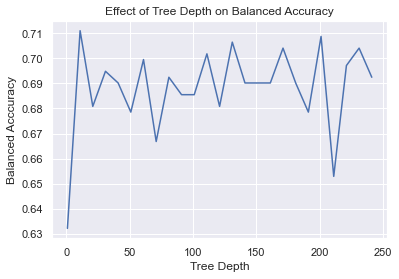

In [36]:
plt.plot(param_arr_depth, ba_arr_depth)
plt.title('Effect of Tree Depth on Balanced Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [37]:
best_depth = param_arr_depth[np.where(ba_arr_depth == np.max(ba_arr_depth))[0][0]]

In [38]:
print("Balanced Accuracy is maximized at a Tree Depth of %s. However, it's possible that so many trees lead to \noverfitting." % best_depth)



Balanced Accuracy is maximized at a Tree Depth of 11.0. However, it's possible that so many trees lead to 
overfitting.


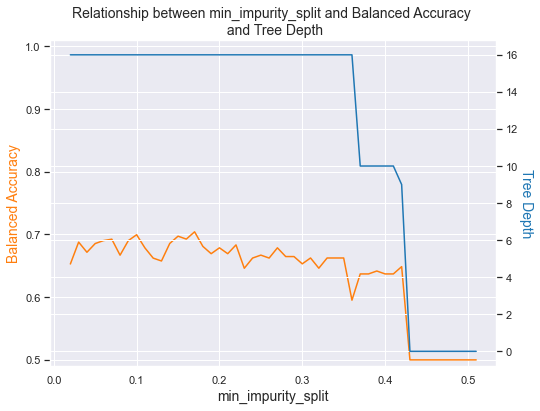

In [39]:
plot_tree_arr(param_arr_imp_split, ba_arr_imp_split, depth_arr_imp_split, param='min_impurity_split')

In [40]:
best_imp_split = param_arr_imp_split[np.where(ba_arr_imp_split == np.max(ba_arr_imp_split))[0][0]]

In [41]:
best_imp_split_depth = depth_arr_imp_split[np.where(ba_arr_imp_split == np.max(ba_arr_imp_split))[0][0]]

In [42]:
print("Balanced Accuracy is maximized when min_impurity_split = %f with a tree depth of %s. When min_impurity_split > ~0.4, there are too few splits leading to underfitting." % (best_imp_split, best_imp_split_depth))



Balanced Accuracy is maximized when min_impurity_split = 0.170000 with a tree depth of 16.0. When min_impurity_split > ~0.4, there are too few splits leading to underfitting.


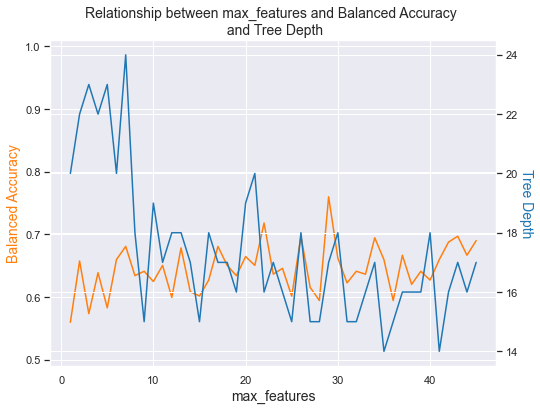

In [43]:
plot_tree_arr(param_arr_features, ba_arr_features, depth_arr_features, param='max_features')

In [44]:
best_features = param_arr_features[np.where(ba_arr_features == np.max(ba_arr_features))[0][0]]

In [45]:
best_features_depth = depth_arr_features[np.where(ba_arr_features == np.max(ba_arr_features))[0][0]]

In [46]:
print("Overall, increasing the number of max_features improves Balanced Accuracy. Balanced Accuracy is maximized when \nmax_features = %s with a tree depth of %s." %(best_features, best_features_depth))


Overall, increasing the number of max_features improves Balanced Accuracy. Balanced Accuracy is maximized when 
max_features = 29.0 with a tree depth of 17.0.


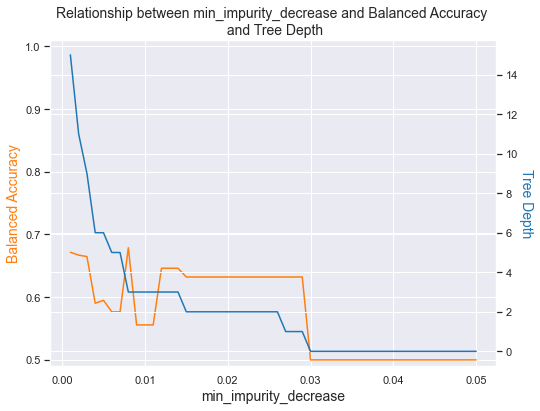

In [47]:
plot_tree_arr(param_arr_imp_dec, ba_arr_imp_dec, depth_arr_imp_dec, param='min_impurity_decrease')

In [48]:
best_imp_dec = param_arr_imp_dec[np.where(ba_arr_imp_dec == np.max(ba_arr_imp_dec))[0][0]]

In [49]:
print("Balanced Accuracy is maximized when min_impurity_decrease = %f." % best_imp_dec)

Balanced Accuracy is maximized when min_impurity_decrease = 0.008000.


#### Random Forest

In [50]:
param = 'n_estimators'

# set start, stop, step
start = 1
stop = 201
step = 10

n_samples = np.int(round((stop - start)/step, 0))

param_arr_est = np.arange(start, stop, step)
ba_arr_est = np.zeros(n_samples)
depth_arr_est = np.zeros(n_samples)

for idx, val in tqdm(enumerate(param_arr_est)):    
    new_forest = RandomForestClassifier(n_estimators=val).fit(X_train, y_train)
    new_forest_y_valid_pred = new_forest.predict(X_valid)
    
    ba_arr_est[idx], param_arr_est[idx], depth_arr_est[idx] = balanced_accuracy_score(y_valid, new_forest_y_valid_pred), val, len(new_forest.estimators_)
    
    

20it [00:04,  4.17it/s]


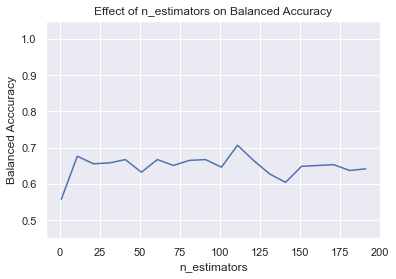

In [51]:
plt.plot(param_arr_est, ba_arr_est)
plt.title('Effect of n_estimators on Balanced Accuracy')
plt.ylim([0.45,1.05])
plt.xlabel('n_estimators')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [52]:
print("Increasing n_estimators appears to marginally improve Balanced Accuracy, but may lead to overfitting.")

Increasing n_estimators appears to marginally improve Balanced Accuracy, but may lead to overfitting.


#### Compute fairness metrics at different values for max_depth

In [53]:
privileged_groups = [{'sex': 1, 'age': 1}]
unprivileged_groups = [{'sex': 0, 'age': 0}]

# select dataset
d1 = dataset_test
d2 = dataset_test_pred

In [54]:
bal_acc_arr = []
mean_diff_arr = []
avg_odds_arr = []
disp_imp_arr = []
indiv_fair_arr = []

# needs to be the same for original and transformed datasets
param_arr = np.arange(1, 26, 1)

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train, y_train)
    new_tree_y_test_pred = new_tree.predict(X_test).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    avg_odds_arr.append(metrics_test.average_odds_difference())
    disp_imp_arr.append(metrics_test.disparate_impact())
    indiv_fair_arr.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from original testing data

100%|██████████| 25/25 [00:00<00:00, 94.58it/s]


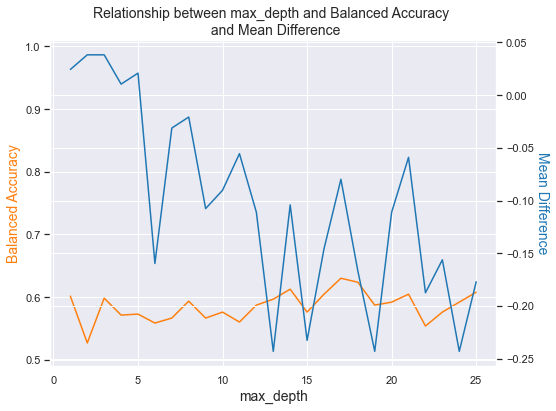

In [55]:
plot_tree_arr(param_arr, bal_acc_arr, mean_diff_arr, param='max_depth', metric_name='Mean Difference')

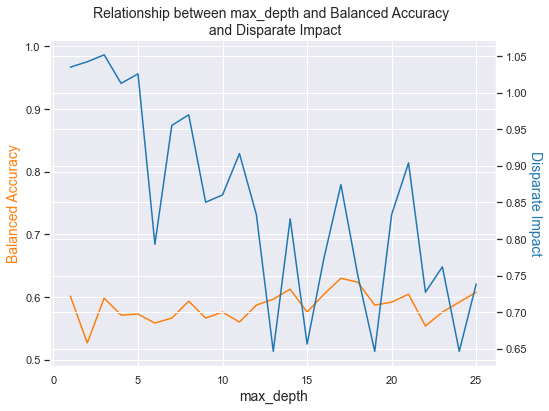

In [56]:
plot_tree_arr(param_arr, bal_acc_arr, disp_imp_arr, param='max_depth', metric_name='Disparate Impact')

#### Train on transformed data

In [57]:
# 70:30 split into train, test
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True)

#### Train

In [58]:
X_train_transf = dataset_transf_train.features
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

tree_transf = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree_transf.predict(X_train)

#### Test

In [59]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = dataset_transf_test_pred.features
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = tree_transf.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [60]:
# select dataset
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [61]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
mean_diff_arr_transf = []
avg_odds_arr_transf = []
disp_imp_arr_transf = []
indiv_fair_arr_transf = []

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train_transf, y_train_transf)
    new_tree_y_test_pred_transf = new_tree.predict(X_test_transf).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred_transf
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)
    
    mean_diff_arr_transf.append(metrics_test.mean_difference())    
    avg_odds_arr_transf.append(metrics_test.average_odds_difference())
    disp_imp_arr_transf.append(metrics_test.disparate_impact())
    indiv_fair_arr_transf.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from transformed testing data

100%|██████████| 25/25 [00:00<00:00, 73.64it/s]


<a id='tradeoffs'></a>

[Go to top](#main)

### 4. Tradeoffs

In [62]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Decision Tree Depth', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    # ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

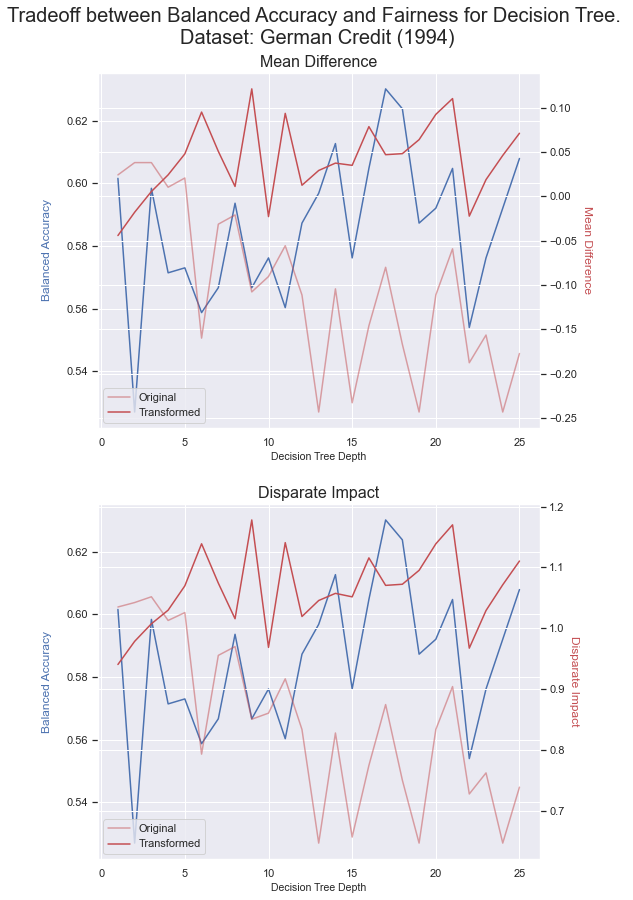

In [63]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,12))

plot_tradeoffs(param_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(param_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[1], name='Disparate Impact')

fig.tight_layout(h_pad=2, w_pad=2.5)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Decision Tree. \nDataset: German Credit (1994)', 
             x=0.5, y=1.04, size=20)
plt.show()

[Go to top](#main)